# A mathematical vulgarization of Surrogate-Based Optimization

## Version information and imports

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv

## 0) Introduction

This tutorial is a lighthearted introduction to surrogate-assisted optimization with a simple example, without using external libraries except numpy and matplotlib, nor exhaustive mathematical definitions and examples. 

The aim of surrogate-assisted optimization is to replace the objective function that could be expensive to evaluate,  by a gaussian process surrogate model. The principle is as follows: 


![Vulgamaths_Surrogate.jpg](Images/Vulgamaths_Surrogate.jpg)
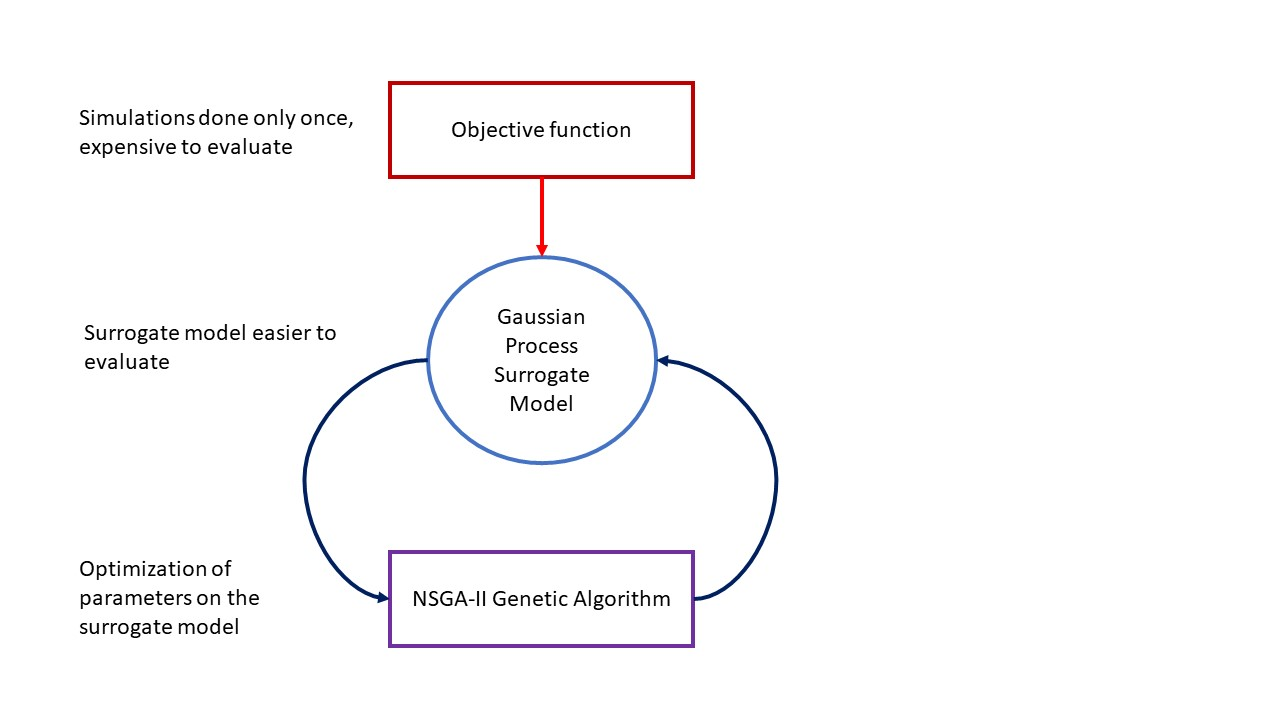

<a id='index'></a>
This tutorial will be organized as follows:
1. [Gaussian Process](#section_1)
2. [Prior and Posterior](#section_2)
3. [Exploration](#section_3)
4. [Libraries Used in Pyleecan](#section_4)

Along the tutorial, we will use a simple example of cosinus objective function to illustrate the concepts. 

<a id='section_1'></a>
## 1) Gaussian Process
[Return to index](#index)

### 1.1) Definition

Given an objective function $f$, $n$ sample points ${ (x_i) }_{i=1...n}$ are chosen to be evaluated to obtain $(f(x_i))$, denoted as $(y_i)$. A gaussian process on these sample points are a specific gaussian distribution defined as: 

$$
\begin{bmatrix}
y_1\\ \vdots \\
y_n
\end{bmatrix} \sim \mathcal{N}
\begin{pmatrix}
\begin{bmatrix}
m(y_1)\\ \vdots \\m(y_n)
\end{bmatrix} , 
\begin{bmatrix}
k(x_1, x_1) \dots k(x_1, x_n) \\
\vdots \ddots \vdots\\
k(x_n, x_1) \dots k(x_n, x_n)
\end{bmatrix}
\end{pmatrix}
$$

where m is the mean function and k is the covariance function, also known as kernel. 

A simpler notation is to define $X$ as $\begin{bmatrix} x_1 \dots x_n \end{bmatrix}^T $, then:

$$
Y = f(X) \sim \mathcal{N}(m(X),k(X,X))
$$

The choice of the mean function is not often discussed, since the influence of the kernel choice is much more pronounced.

The kernel function models the covariance between each $x_i$ and $x_j$. Therefore, it needs to be symmetric and positive-definite. 

Making a choice on the kernel function can be viewed as setting a prior information on how we would fit the objective function. This point of view could be interesting for the [second section](section_2), as fitting the gaussian model onto the function to construct a surrogate model could be seen as adding information from the reality to obtain a posterior.

### 1.2) Usual choice of kernel 
Given $\sigma$ a variance, there are different types of usual kernels with varying complexity, from the simplest white noise kernel $k(X,X) = \sigma^2 I_n$ to more complicated kernels such as periodic kernels. We will introduce the squared exponential kernel: 

$
\forall x_i, x_j \in (x_i)_{i=1...n}\\ $
$$
k(x_i, x_j) = \sigma^2 \exp{(-\frac{\lVert x_i - x_j \rVert^2}{2l^2})}
$$
where $l$ is the characteristic length-scale, which is the distance required for the function to change significantly.
We will plot a few samples of gaussian process using this kernel, and with zero mean. 


In [24]:
def squared_exp_kernel(X1, X2, l=1.0, sigma=1.0):

    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma**2 * np.exp(-0.5 / l**2 * sqdist)

def plot_gaussian(mean, covariance, X, realizations):
    X = X.ravel()
    mean = mean.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(covariance))
    
    plt.fill_between(X, mean + uncertainty, mean - uncertainty, alpha=0.1)
    plt.plot(X, mean, label='Mean')
    for i, rel in enumerate(realizations):
        plt.plot(X, rel, lw=1, ls='--', label=f'Realization {i+1}')
    plt.legend()

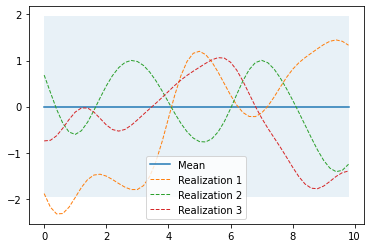

In [25]:
# The sample
X = np.arange(0, 10, 0.2).reshape(-1, 1)
l = 1.0
sigma = 1.0

mean = np.zeros(X.shape)
covariance = squared_exp_kernel(X, X, l=l, sigma=sigma)

# We plot three realizations of the Gaussian process
realizations = np.random.multivariate_normal(mean.ravel(), covariance, 3)
plot_gaussian(mean, covariance, X, realizations)


The blue area is 1.96 standard deviations of the mean, in which the value of the Gaussian process at one point have 95% probability to be.

This kernel provides smoother samples compared to the other usual kernels. It is one of the most used kernels. The influence of $l$ and $\sigma$ can clearly be observed: when $l$ increases, the variation of the samples becomes slower or more spread out. When $\sigma$ increases, the range of values attained by the variation of the sample increases.

<a id='section_2'></a>
## 2) Prior and Posterior
[Return to index](#index)

As mentioned above, the kernel defines a **prior** for fitting our objective function. Similar to Bayesian Statistics, we will used **information** from the objective function to construct a **posterior predictive function** which can predict the other points on the objective function.
But what exactly is a prior, information and posterior in layman's terms? 


Hopefully we all know and cherish the famous Bayes theorem in probability theory: for two events $A$ and $B$ with $\mathbb{P}(B) \neq 0$ 

$$
\mathbb{P}(A|B) = \frac{\mathbb{P}(B|A) \mathbb{P}(A)}{\mathbb{P}(B)}
$$

In Bayesian statistics we like to interpret $\mathbb{P}(B)$ as a "normalization factor", therefore we often abuse the proportional symbol, which is of course partially untrue since the $\mathbb{P}(B)$ literally depends on B : 

$$
\mathbb{P}(A|B) \propto \mathbb{P}(B|A) \mathbb{P}(A)
$$

But, what if we see $A$ as our prior information, $B|A$ as new information gained by assuming our prior information is true?
Then according to Bayes theorem, we can think $A|B$ as a posterior information obtained by improving our prior $A$ by using more information $B|A$!
Returning to the case of the Gaussian process, we now need to add an index to X and Y to separate prior from posterior. 

With the choice of a kernel made as explained above, we will have drawn the first set of $n_1$ samples $X_1$ and have defined: 

$$
Y_1 = f(X_1) \sim \mathcal{N}(m(X_1),k(X_1,X_1))
$$

If we note $\mu_1 = m(X_1)$ and $\Sigma_1 = k(X_1,X_1)$, then

$$
Y_1 = f(X_1) \sim \mathcal{N}(\mu_1,\Sigma_1)
$$

The next step would be naturally to draw a new set of $n_2$ samples $X_2$ and try to predict the values of $f(X_2)$ based on our prior $Y_1$ and the first set of samples $X_1$. Which gaussian process do we use to predict $Y_2 = f(X_2)$? Well, our lord and savior Bayes has the answer. 

Referring back to the Bayes theorem, if we see the prior A as $Y_1$, and $X_1$ as B, then the Bayes theorem states that:

$$
\mathbb{P}(Y_1|X_1) \propto \mathbb{P}(X_1|Y_1) \mathbb{P}(Y_1)
$$

We easily obtain $Y_1|X_1$ which is known as the posterior. We can view the posterior as the result obtained by "training" the prior by using the sample set $X_1$ and $Y_1$.

We nauturally want to use this posterior to predict the values of the objective function at the points $X_2$. However, the prediction of the value of $y_2=f(x_2)$ on just one point of the new sample $x_2 \in X_2$ is not just a single guess “$y_2$”, but rather an entire probability distribution over possible outputs. Therefore, we can obtain the posterior predictive function (denoted as $Y_2|X_2,Y_1,X_1$) from a rather complex integration which will take into account the whole posterior just to predict at one point $y_2$. However, in the case of Gaussian Process Regression (which is what we are essentially doing by fitting our objective function), a simple**r** (that does not mean it is simple) result can be deduced from the fact that $Y_1$ and $Y_2$ forms a joint distribution, i.e. if a prior is Gaussian then the posterior is also Gaussian. The result is as follows: 

Given a kernel k, we denote 
1. $K_1 = k(X_1,X_1)$
2. $K_{12} = k(X_1,X_2)$
3. $K_2 = k(X_2,X_2)$

then, the posterior predictive function is given by

$$
Y_2|X_2,Y_1,X_1 \sim \mathcal{N}(\mu_2, \Sigma_2)
$$

where
$$
\mu_2 = K_{12}^T K_1^{-1}Y_1 \\
\Sigma_2 = K_2 - K_{12}^T K_1^{-1}K_{12}
$$

In practice, to code these it's literally the same as the prior with a new mean and kernel function. 

Just a little more nomenclature,
1. $X_1$ and $Y_1$ are known as the training set (we train the prior) 
2. $X_2$ and $Y_2$ are known as the testing set (similar to machine learning huh?)

In [26]:
def post_pred_func(X_2, X_1, Y_1, l=1.0, sigma=1.0):
    
    K_1  = squared_exp_kernel(X_1, X_1, l, sigma)  
    K_12 = squared_exp_kernel(X_1, X_2, l, sigma)
    K_2  = squared_exp_kernel(X_2, X_2, l, sigma)
    K_inv = inv(K_1)
    
    mu_2 = K_12.T.dot(K_inv).dot(Y_1)

    # Equation (8)
    cov_2 = K_2 - K_12.T.dot(K_inv).dot(K_12)
    
    return mu_2, cov_2

def plot_post_gaussian(mu, cov, X_2, X_1, Y_1, realizations):
    X_2 = X_2.ravel()
    mu = mu.ravel()
    uncertainty = 1.96 * np.sqrt(np.diag(cov))
    
    plt.fill_between(X_2, mu + uncertainty, mu - uncertainty, alpha=0.1)
    plt.plot(X_2, mu, label='Mean')
    for i, rel in enumerate(realizations):
        plt.plot(X_2, rel, lw=1, ls='--', label=f'Realization {i+1}')

    plt.plot(X_1, Y_1, 'rx')
    plt.legend()

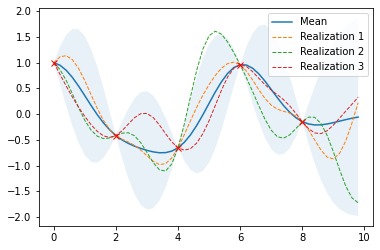

In [27]:
# The first sample that we use to "train" the prior into posterior
# It has as less points as possible since it requires
# the evaluation of objective function at these points
X_1 = np.arange(0, 10, 2).reshape(-1, 1)
Y_1 = np.cos(X_1) #we evaluate the objective function (expensive in reality)

# The second sample that we will test our posterior predictive function on
X_2 = np.arange(0, 10, 0.2).reshape(-1, 1)

# Compute mean and covariance of the posterior predictive function
mu_2, cov_2 = post_pred_func(X_2, X_1, Y_1)

#We plot three realizations of the Gaussian process
realizations = np.random.multivariate_normal(mu_2.ravel(), cov_2, 3)
plot_post_gaussian(mu_2, cov_2, X_2, X_1, Y_1, realizations)

We can change the number of points in the first sample or even carry out sampling in irregular intervals to observe the impact on the posterior predictive function.

<a id='section_3'></a>
## 3) Exploration
[Return to index](#index)


The mean and covariance of the posterior predictive function are basically only determined by the kernel (which is just a choice according to the anticipated smoothness of the objective function), and the first sample. The first sample is by far the determining factor(just play with the code above). Therefore, the sample points, like all things in life, has to be **optimized**. This is crucial and is what puts the word optimization into surrogate-based optimization. We call this step exploration. We will go over three types of exploration. This part is heavily inspired by the lecture of Mr. Joseph Morlier given to us.

### 3.1) Prediction-Based Exploration
When using a Gaussian process surrogate model, prediction-based
exploration chooses the sample points such that it simply **minimizes** the difference between the mean function and the objective function. It ignores uncertainty.

### 3.2) Error-Based Exploration
For Gaussian processes, error-based exploration simply **minimizes** the
maximum standard deviation within a specified domain. 

### 3.3) Lower Confidence Bound Exploration

This is a tradeoff between the above two ways of exploration. The next sample **minimizes** the lower confidence bound of the objective function, defined as:
$$
LB(x) = mu(x) - \alpha\sigma(x)
$$
where $\alpha \geq 0$ is the tradeoff parameter. 

### 2.3) Role of NSGA-II
Well, the previous paragraphes mentioned minimization. That's it, that's the role of NSGA-II.

<a id='section_4'></a>
## 4) Libraries Used in Pyleecan
[Return to index](#index)

To carry out the surrogate-based optimization, we used [smoot library](https://pypi.org/project/smoot/), which is an extension of [smt library](https://smt.readthedocs.io/en/latest/) which allows for the generalization of smt into multi-objective optimization. smoot uses NSGA-II from [pymoo](https://pymoo.org/) for the optimization part.